In [1]:
import pandas as pd
df = pd.read_csv("train.csv")

df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [2]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})

In [5]:
df["Age"] = df["Age"].fillna(df["Age"].mean())

In [6]:
df["Embarked"] = df["Embarked"].map({"S" : 0,"C" :1 ,"Q": 2})

In [7]:
dfd = df.drop(columns=["Cabin","Name","Ticket","Fare"])

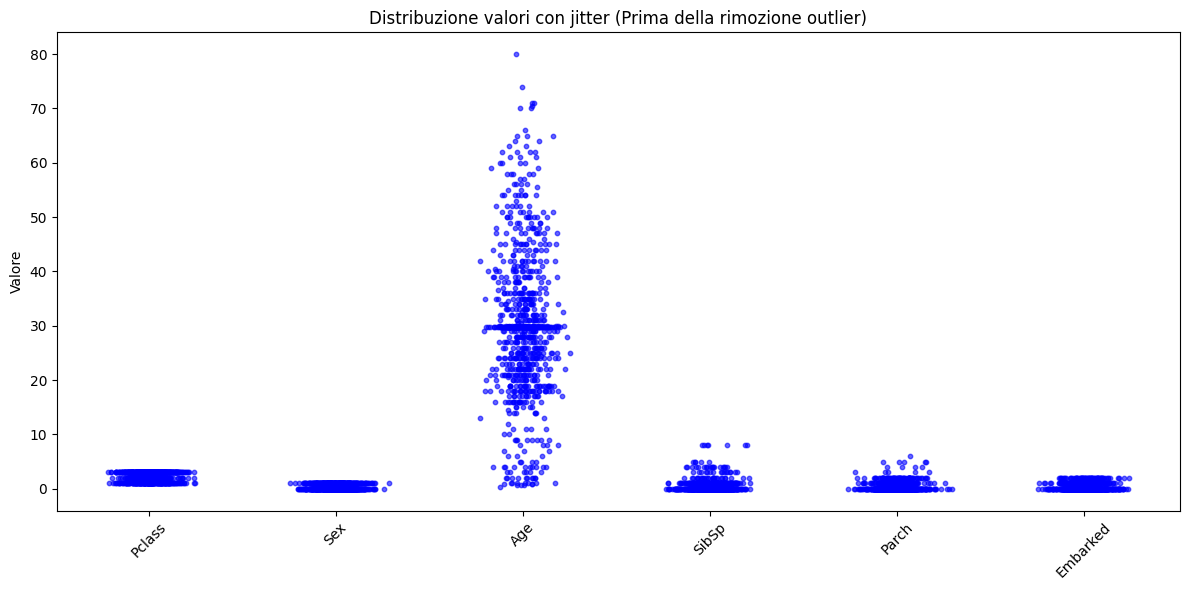

In [8]:
import matplotlib.pyplot as plt
import numpy as np


numeric_cols = dfd.select_dtypes(include=[np.number]).columns
numeric_cols = numeric_cols.drop(["Survived"])
numeric_cols = [col for col in numeric_cols if col != "PassengerId"]

plt.figure(figsize=(12, 6))

for i, col in enumerate(numeric_cols):
    data = dfd[col].dropna()  
    if len(data) == 0:
        continue
    
    # Jitter sull'asse x
    x = np.random.normal(i, 0.08, size=len(data))
    plt.scatter(x, data.values, alpha=0.6, s=10, color='blue')

plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45)
plt.title("Distribuzione valori con jitter (Prima della rimozione outlier)")
plt.ylabel("Valore")
plt.tight_layout()
plt.show()


In [9]:
dfd.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       2
dtype: int64

In [10]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    dfd[col] = np.where(dfd[col].between(lower, upper), dfd[col], np.nan)

In [11]:
from sklearn.model_selection import train_test_split


X = dfd[numeric_cols].copy()
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [12]:
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

X = dfd[numeric_cols].copy()          
y = df['Survived']                     

X = X.fillna(X.median())


c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 0.5),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 9.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 8.0, log=True),
        'n_jobs': -1,
        'random_state': 41,
        'tree_method': 'hist', 
        'device': 'cuda'    
    }

    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return scores.mean()


study = optuna.create_study(direction='maximize', study_name="XGBoost_Titanic")
study.optimize(objective, n_trials=50, show_progress_bar=True)


print("\n--- Risultati Ottimizzazione ---")
print(f"Miglior Trial (Tentativo #{study.best_trial.number})")
print(f"Accuratezza Migliore (CV): {study.best_value:.4f}")
print("Migliori Iperparametri:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)
final_acc = final_model.score(X_test, y_test)
print(f"\nAccuratezza Finale sul Test Set: {final_acc:.4f}")


[I 2025-12-05 11:21:30,269] A new study created in memory with name: XGBoost_Titanic
  0%|          | 0/50 [00:00<?, ?it/s]

[11:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



Best trial: 0. Best value: 0.802529:   2%|▏         | 1/50 [00:03<02:27,  3.01s/it]

[I 2025-12-05 11:21:33,278] Trial 0 finished with value: 0.8025290322580645 and parameters: {'n_estimators': 456, 'learning_rate': 0.003136401957042965, 'max_depth': 9, 'subsample': 0.41343977011410726, 'colsample_bytree': 0.6228961785188278, 'reg_alpha': 0.09211362352815276, 'reg_lambda': 7.648696088712395e-07}. Best is trial 0 with value: 0.8025290322580645.
[11:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:34] WARNING: C:\buildkite-agent\builds\bui

Best trial: 0. Best value: 0.802529:   4%|▍         | 2/50 [00:05<01:57,  2.44s/it]

[I 2025-12-05 11:21:35,319] Trial 1 finished with value: 0.7993419354838709 and parameters: {'n_estimators': 339, 'learning_rate': 0.0016530344268200336, 'max_depth': 6, 'subsample': 0.4943375693299342, 'colsample_bytree': 0.7224813115579387, 'reg_alpha': 0.011270889262111755, 'reg_lambda': 3.599457469253081e-08}. Best is trial 0 with value: 0.8025290322580645.
[11:21:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:37] WARNING: C:\buildkite-agent\builds\bu

Best trial: 0. Best value: 0.802529:   6%|▌         | 3/50 [00:08<02:15,  2.89s/it]

[I 2025-12-05 11:21:38,749] Trial 2 finished with value: 0.7896645161290323 and parameters: {'n_estimators': 889, 'learning_rate': 0.006566984367245431, 'max_depth': 4, 'subsample': 0.23918678558753503, 'colsample_bytree': 0.3843517294826353, 'reg_alpha': 3.528057472555414e-05, 'reg_lambda': 3.5036119695470415e-05}. Best is trial 0 with value: 0.8025290322580645.
[11:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:40] WARNING: C:\buildkite-agent\builds\

Best trial: 0. Best value: 0.802529:   8%|▊         | 4/50 [00:11<02:14,  2.92s/it]

[I 2025-12-05 11:21:41,719] Trial 3 finished with value: 0.7800774193548389 and parameters: {'n_estimators': 780, 'learning_rate': 0.21018997970514813, 'max_depth': 6, 'subsample': 0.14067954494682275, 'colsample_bytree': 0.6162019467279596, 'reg_alpha': 0.00035650082594140787, 'reg_lambda': 0.00022866633370309379}. Best is trial 0 with value: 0.8025290322580645.
[11:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:43] WARNING: C:\buildkite-agent\builds\

Best trial: 0. Best value: 0.802529:  10%|█         | 5/50 [00:13<01:57,  2.60s/it]

[I 2025-12-05 11:21:43,749] Trial 4 finished with value: 0.7865032258064517 and parameters: {'n_estimators': 586, 'learning_rate': 0.13225332609831983, 'max_depth': 7, 'subsample': 0.11443835834089336, 'colsample_bytree': 0.43163996323672993, 'reg_alpha': 0.004226128250440974, 'reg_lambda': 1.1229097825659735}. Best is trial 0 with value: 0.8025290322580645.
[11:21:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:45] WARNING: C:\buildkite-agent\builds\build

Best trial: 0. Best value: 0.802529:  12%|█▏        | 6/50 [00:17<02:09,  2.94s/it]

[I 2025-12-05 11:21:47,355] Trial 5 finished with value: 0.7993161290322581 and parameters: {'n_estimators': 635, 'learning_rate': 0.12465579702978496, 'max_depth': 8, 'subsample': 0.28491145102222815, 'colsample_bytree': 0.575235994489207, 'reg_alpha': 1.8678285492818398e-07, 'reg_lambda': 0.00023878434751952587}. Best is trial 0 with value: 0.8025290322580645.
[11:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:50] WARNING: C:\buildkite-agent\builds\b

Best trial: 6. Best value: 0.807381:  14%|█▍        | 7/50 [00:21<02:32,  3.54s/it]

[I 2025-12-05 11:21:52,133] Trial 6 finished with value: 0.8073806451612903 and parameters: {'n_estimators': 926, 'learning_rate': 0.001216851120639895, 'max_depth': 8, 'subsample': 0.49487090074298457, 'colsample_bytree': 0.5505321735420063, 'reg_alpha': 1.0414350971738557, 'reg_lambda': 0.0031399379826632886}. Best is trial 6 with value: 0.8073806451612903.
[11:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:53] WARNING: C:\buildkite-agent\builds\buil

Best trial: 6. Best value: 0.807381:  16%|█▌        | 8/50 [00:24<02:14,  3.19s/it]

[I 2025-12-05 11:21:54,581] Trial 7 finished with value: 0.8009548387096774 and parameters: {'n_estimators': 535, 'learning_rate': 0.0012213664526303846, 'max_depth': 4, 'subsample': 0.4189385492821389, 'colsample_bytree': 0.6017955542917077, 'reg_alpha': 0.014164686909921152, 'reg_lambda': 4.5494951406679734e-08}. Best is trial 6 with value: 0.8073806451612903.
[11:21:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:56] WARNING: C:\buildkite-agent\builds\b

Best trial: 8. Best value: 0.808994:  18%|█▊        | 9/50 [00:26<02:02,  2.98s/it]

[I 2025-12-05 11:21:57,103] Trial 8 finished with value: 0.8089935483870969 and parameters: {'n_estimators': 876, 'learning_rate': 0.007110564781582149, 'max_depth': 8, 'subsample': 0.3095159200344374, 'colsample_bytree': 0.6384930674220821, 'reg_alpha': 8.117612881975868, 'reg_lambda': 7.444840295433137e-08}. Best is trial 8 with value: 0.8089935483870969.
[11:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:21:58] WARNING: C:\buildkite-agent\builds\buildk

Best trial: 8. Best value: 0.808994:  20%|██        | 10/50 [00:29<01:53,  2.84s/it]

[I 2025-12-05 11:21:59,620] Trial 9 finished with value: 0.8057419354838709 and parameters: {'n_estimators': 342, 'learning_rate': 0.044366241126046056, 'max_depth': 9, 'subsample': 0.4026212677779921, 'colsample_bytree': 0.7200549846775706, 'reg_alpha': 0.006127475664529941, 'reg_lambda': 1.1861403393260057e-06}. Best is trial 8 with value: 0.8089935483870969.
[11:21:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:02] WARNING: C:\buildkite-agent\builds\bu

Best trial: 8. Best value: 0.808994:  22%|██▏       | 11/50 [00:33<02:09,  3.32s/it]

[I 2025-12-05 11:22:04,018] Trial 10 finished with value: 0.8089419354838709 and parameters: {'n_estimators': 734, 'learning_rate': 0.016700943516316753, 'max_depth': 10, 'subsample': 0.216715939026688, 'colsample_bytree': 0.7990837155964445, 'reg_alpha': 1.0626093472972906e-08, 'reg_lambda': 0.0728445701046725}. Best is trial 8 with value: 0.8089935483870969.
[11:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:06] WARNING: C:\buildkite-agent\builds\bui

Best trial: 8. Best value: 0.808994:  24%|██▍       | 12/50 [00:38<02:18,  3.66s/it]

[I 2025-12-05 11:22:08,449] Trial 11 finished with value: 0.8009290322580644 and parameters: {'n_estimators': 784, 'learning_rate': 0.014517867901119098, 'max_depth': 10, 'subsample': 0.1934488676565519, 'colsample_bytree': 0.7998472902451463, 'reg_alpha': 1.3713631963568623e-08, 'reg_lambda': 0.12113268310322056}. Best is trial 8 with value: 0.8089935483870969.
[11:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:09] WARNING: C:\buildkite-agent\builds\b

Best trial: 8. Best value: 0.808994:  26%|██▌       | 13/50 [00:40<01:55,  3.13s/it]

[I 2025-12-05 11:22:10,376] Trial 12 finished with value: 0.800941935483871 and parameters: {'n_estimators': 740, 'learning_rate': 0.02065203329933293, 'max_depth': 10, 'subsample': 0.3210342245224822, 'colsample_bytree': 0.7873513832504746, 'reg_alpha': 7.556303308206902, 'reg_lambda': 0.02324607048090991}. Best is trial 8 with value: 0.8089935483870969.
[11:22:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:12] WARNING: C:\buildkite-agent\builds\buildkit

Best trial: 8. Best value: 0.808994:  28%|██▊       | 14/50 [00:44<02:05,  3.47s/it]

[I 2025-12-05 11:22:14,636] Trial 13 finished with value: 0.8025290322580647 and parameters: {'n_estimators': 996, 'learning_rate': 0.00807484509223473, 'max_depth': 8, 'subsample': 0.319601311221044, 'colsample_bytree': 0.45500632220433945, 'reg_alpha': 2.1964977053488654e-06, 'reg_lambda': 3.9809091420925795}. Best is trial 8 with value: 0.8089935483870969.
[11:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:15] WARNING: C:\buildkite-agent\builds\buil

Best trial: 14. Best value: 0.810555:  30%|███       | 15/50 [00:45<01:33,  2.68s/it]

[I 2025-12-05 11:22:15,470] Trial 14 finished with value: 0.8105548387096775 and parameters: {'n_estimators': 133, 'learning_rate': 0.03579156454241936, 'max_depth': 10, 'subsample': 0.21107910167656302, 'colsample_bytree': 0.6977018286620004, 'reg_alpha': 1.968578985786554e-05, 'reg_lambda': 8.812019408374726e-06}. Best is trial 14 with value: 0.8105548387096775.
[11:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:15] WARNING: C:\buildkite-agent\builds

Best trial: 15. Best value: 0.816994:  32%|███▏      | 16/50 [00:46<01:12,  2.13s/it]

[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[I 2025-12-05 11:22:16,314] Trial 15 finished with value: 0.8169935483870967 and parameters: {'n_estimators': 136, 'learning_rate': 0.04382067661449891, 'max_depth': 7, 'subsample': 0.27193642360001913, 'colsample_bytree': 0.6803485137836085, 'reg_alpha': 3.074107939704231e-05, 'reg_lambda': 4.547644012264492e-06}. Best is trial 15 with value: 0.8169935483870967.
[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:16] WARNING: C:\buildkite-agent\builds\

Best trial: 15. Best value: 0.816994:  34%|███▍      | 17/50 [00:46<00:53,  1.62s/it]

[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[I 2025-12-05 11:22:16,757] Trial 16 finished with value: 0.8009290322580644 and parameters: {'n_estimators': 119, 'learning_rate': 0.05014333159432289, 'max_depth': 3, 'subsample': 0.16936594422668216, 'colsample_bytree': 0.6985255205265096, 'reg_alpha': 1.0410848781700373e-05, 'reg_lambda': 1.0054192220300257e-05}. Best is trial 15 with value: 0.8169935483870967.
[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:17] WARNING: C:\buildkite-agent\build

Best trial: 15. Best value: 0.816994:  36%|███▌      | 18/50 [00:47<00:42,  1.33s/it]

[I 2025-12-05 11:22:17,402] Trial 17 finished with value: 0.796116129032258 and parameters: {'n_estimators': 105, 'learning_rate': 0.06392466930835616, 'max_depth': 7, 'subsample': 0.2549504625662955, 'colsample_bytree': 0.5003884133331821, 'reg_alpha': 0.00024261779792545592, 'reg_lambda': 3.0907719616841777e-06}. Best is trial 15 with value: 0.8169935483870967.
[11:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:18] WARNING: C:\buildkite-agent\builds\

Best trial: 15. Best value: 0.816994:  38%|███▊      | 19/50 [00:48<00:39,  1.27s/it]

[I 2025-12-05 11:22:18,555] Trial 18 finished with value: 0.8089677419354839 and parameters: {'n_estimators': 223, 'learning_rate': 0.029952550901237697, 'max_depth': 5, 'subsample': 0.37006306093120994, 'colsample_bytree': 0.6748077315960165, 'reg_alpha': 4.6250172650655305e-07, 'reg_lambda': 4.336603381251778e-05}. Best is trial 15 with value: 0.8169935483870967.
[11:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:19] WARNING: C:\buildkite-agent\build

Best trial: 15. Best value: 0.816994:  38%|███▊      | 19/50 [00:49<00:39,  1.27s/it]

[11:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[I 2025-12-05 11:22:19,414] Trial 19 finished with value: 0.7671741935483871 and parameters: {'n_estimators': 241, 'learning_rate': 0.09537798120190273, 'max_depth': 9, 'subsample': 0.2659051910693226, 'colsample_bytree': 0.3261925037522604, 'reg_alpha': 0.00019549573437415462, 'reg_lambda': 0.0012036091867881004}. Best is trial 15 with value: 0.8169935483870967.


Best trial: 15. Best value: 0.816994:  40%|████      | 20/50 [00:49<00:34,  1.15s/it]

[11:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

[11:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.



Best trial: 15. Best value: 0.816994:  42%|████▏     | 21/50 [00:50<00:32,  1.14s/it]

[I 2025-12-05 11:22:20,516] Trial 20 finished with value: 0.7945161290322582 and parameters: {'n_estimators': 237, 'learning_rate': 0.22492546443537342, 'max_depth': 6, 'subsample': 0.174849300164708, 'colsample_bytree': 0.7457073282371296, 'reg_alpha': 2.8378893639195112e-05, 'reg_lambda': 3.861832579806383e-07}. Best is trial 15 with value: 0.8169935483870967.
[11:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "device" } are not used.

